# Polynomial Linear Regression

To get started, we look at a simple linear regression example with `cofi`.

We assume a linear problem, for which we know a dataset X, Y and a polynomial forward function with a degree of 3.

In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `InversionRunner`.

- `BaseProblem` describes everything about the forward problem, including how one would like to
  calculate the objective function or one's belief on the model space.
- `InversionOptions` describes details about how one wants to run the inversion, including the
  inversion approach, backend tool and solver-specific parameters.
- `InversionRunner` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
For each of the above components, there's a `summary()` method to check the current status.
  
So a common workflow includes 4 steps:
1. define `BaseProblem`. This can be done:
    - either: through a series of set functions
      ```
      inv_problem = BaseProblem()
      inv_problem.set_objective(some_function_here)
      inv_problem.set_initial_model(a_starting_point)
      ```
    - or: by subclassing `BaseProblem`
      ```
      class MyOwnProblem(BaseProblem):
          def __init__(self, initial_model, whatever_I_want_to_pass_in):
              self.initial_model = initial_model
              self.whatever_I_want_to_pass_in = whatever_I_want_to_pass_in
          def objective(self, model):
              return some_objective_function_value
      ```
  
2. define `InversionOptions`. Some useful methods include:
    - `set_solving_method()` and `suggest_tools()`. Once you've set a solving method (from "least squares"
      and "optimisation", more will be supported), you can use `suggest_tools()` to see a list of backend tools
      to choose from.
      
3. start an `InversionRunner`. This step is common:
   ```
   inv_runner = InversionRunner(inv_problem, inv_options)
   result = inv_runner.run()
   ```
   
4. analyse the result, workflow and redo your experiments with different `InversionOptions`

---
## 0. Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cofi import BaseProblem, InversionOptions, InversionRunner

---
## 1. Define the problem

A list of functions/properties that can be set to `BaseProblem` so far:
- `set_objective()`
- `set_gradient()`
- `set_hessian()`
- `set_hessian_times_vector()`
- `set_residual()`
- `set_jacobian()`
- `set_jacobian_times_vector()`
- `set_data_misfit()`
- `set_regularisation()`
- `set_dataset()`
- `set_dataset_from_file()`
- `set_initial_model()`
- `set_model_shape()`
- `set_bounds`
- `set_constraints`
- `name` (only useful when displaying this problem, no functional use)

Other useful functions:
- `defined_components()` (review what have been set)
- `summary()` (better displayed information)
- `suggest_solvers()` (not implemented yet)

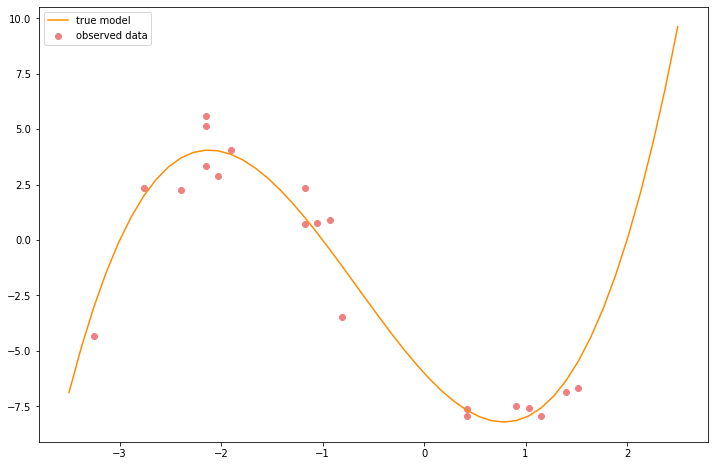

In [2]:
# generate data with random Gaussian noise
basis_func = lambda x: np.array([x**i for i in range(4)]).T               # x -> G
_m_true = np.array([-6,-5,2,1])                                           # m

sample_size = 20                                                          # N
x = np.random.choice(np.linspace(-3.5,2.5), size=sample_size)             # x
forward_func = lambda m: basis_func(x) @ m                                # m -> y_synthetic
y_observed = forward_func(_m_true) + np.random.normal(0,1,sample_size)    # d

############## PLOTTING ###############################################################
_x_plot = np.linspace(-3.5,2.5)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true
plt.figure(figsize=(12,8))
plt.plot(_x_plot, _y_plot, color="darkorange", label="true model")
plt.scatter(x, y_observed, color="lightcoral", label="observed data")
plt.legend()

In [3]:
# define the problem
inv_problem = BaseProblem()
inv_problem.name = "Polynomial Regression"
inv_problem.set_dataset(x, y_observed)
inv_problem.set_forward(forward_func)
inv_problem.set_jacobian(basis_func(x))

inv_problem.summary()

Summary for inversion problem: Polynomial Regression
Model shape: Unknown
----------------------------------------------------
List of functions / properties defined:
{'jacobian_times_vector', 'dataset', 'forward', 'jacobian', 'residual'}


---
## 2. Define the inversion

In [4]:
inv_options = InversionOptions()
inv_options.summary()

Summary for inversion options
Solving method: Not set yet
Backend tool: scipy.optimize.minimize (by default)
-----------------------------
Solver-specific parameters: Not set yet


In [5]:
inv_options.suggest_tools()

Here's a complete list of inversion solvers supported by CoFI (grouped by methods):
{
    "optimisation": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares"
    ],
    "least square": [
        "numpy.linalg.lstsq"
    ]
}


In [6]:
inv_options.set_solving_method("least square")
inv_options.summary()

Summary for inversion options
Solving method: least square
Backend tool: numpy.linalg.lstsq (by default)
-----------------------------
Solver-specific parameters: Not set yet


---

As the "summary" suggested, you've set the solving method, so you can skip the step of
setting a backend tool because there's a default one.

If there are more backend tool options, then use the following function to see available
options and set your desired backend solver.

In [7]:
inv_options.suggest_tools()

Based on the solving method you've set, the following tools are suggested:
['numpy.linalg.lstsq']

Use `InversionOptions.set_tool(tool_name)` to set a specific tool from above
Use `InversionOptions.set_solving_method(tool_name)` to change solving method
Use `InversionOptions.unset_solving_method()` if you'd like to see more options
Check CoFI documentation 'Advanced Usage' section for how to plug in your own solver


In [8]:
inv_options.set_tool("numpy.linalg.lstsq")
inv_options.summary()

Summary for inversion options
Solving method: least square
Backend tool: numpy.linalg.lstsq
-----------------------------
Solver-specific parameters: Not set yet


---
## 3. Start an inversion runner

In [9]:
inv_runner = InversionRunner(inv_problem, inv_options)
inv_runner.summary()

Summary for inversion runner
Inversion hasn't started, try `runner.run()` to see result
---------------------------------------
With inversion solver defined as below:

Summary for inversion options
Solving method: least square
Backend tool: numpy.linalg.lstsq
Solver-specific parameters: Not set yet
---------------------------------------
For inversion problem defined as below:

Summary for inversion problem: Polynomial Regression
Model shape: Unknown
List of functions / properties defined:
{'jacobian_times_vector', 'dataset', 'forward', 'jacobian', 'residual'}


In [10]:
inv_result = inv_runner.run()
inv_result.success

True

In [11]:
inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
model: [-5.85374822 -5.26099189  1.86248227  1.01272161]
residuals: [18.79902044]
rank: 4
singular_values: [51.06709166  6.80490797  3.81712942  1.77872635]


---
## 4. Check back your problem setting, inversion setting & result

In [12]:
inv_runner.summary()

Summary for inversion runner
Trained with the following result:

Summary for inversion result
SUCCESS
model: [-5.85374822 -5.26099189  1.86248227  1.01272161]
residuals: [18.79902044]
rank: 4
singular_values: [51.06709166  6.80490797  3.81712942  1.77872635]
---------------------------------------
With inversion solver defined as below:

Summary for inversion options
Solving method: least square
Backend tool: numpy.linalg.lstsq
Solver-specific parameters: Not set yet
---------------------------------------
For inversion problem defined as below:

Summary for inversion problem: Polynomial Regression
Model shape: Unknown
List of functions / properties defined:
{'jacobian_times_vector', 'dataset', 'forward', 'jacobian', 'residual'}


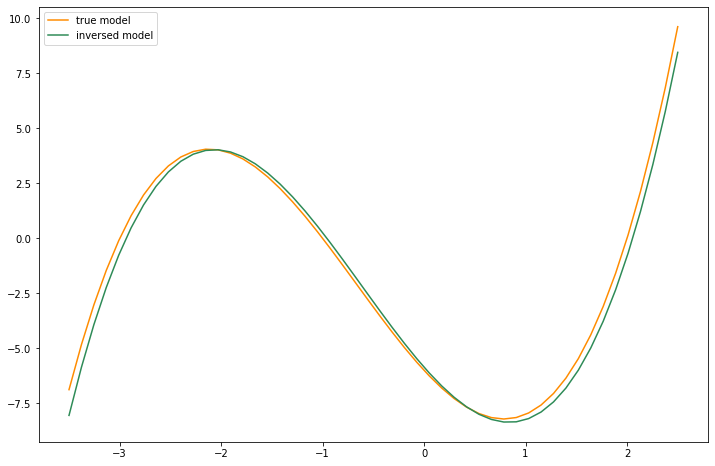

In [13]:
y_synthetic = inv_problem.forward(inv_result.model)

############## PLOTTING ###############################################################
_x_plot = np.linspace(-3.5,2.5)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true
_y_synth = _G_plot @ inv_result.model
plt.figure(figsize=(12,8))
plt.plot(_x_plot, _y_plot, color="darkorange", label="true model")
plt.plot(_x_plot, _y_synth, color="seagreen", label="inversed model")
plt.legend()

---